In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import reprlib
import logging
import sys
from common.filter_banks import make_gauss_kernels, make_dog_kernels
from common.filter_banks import wave_numbers, make_sine_kernels
from common.filter_banks import show_filter_bank
from common.image_ops import resize_img, whiten_img

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
logging.info('Logging begin')

2020-09-25 14:46:08,120 | INFO : Logging begin


4 4


<IPython.core.display.Javascript object>


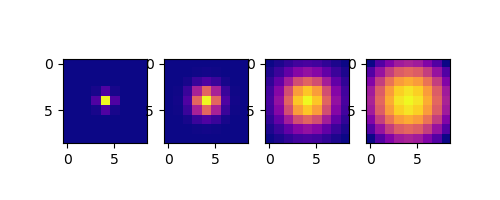

In [2]:
%matplotlib notebook
gauss_kernels = make_gauss_kernels()
show_filter_bank(gauss_kernels)

4 4


<IPython.core.display.Javascript object>


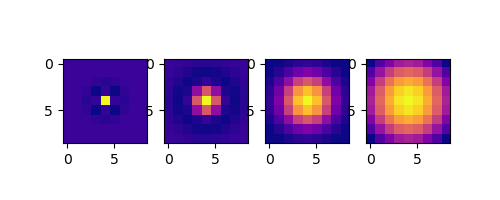

In [3]:
%matplotlib notebook
dog_kernels = make_dog_kernels()
show_filter_bank(dog_kernels)

12 12


<IPython.core.display.Javascript object>


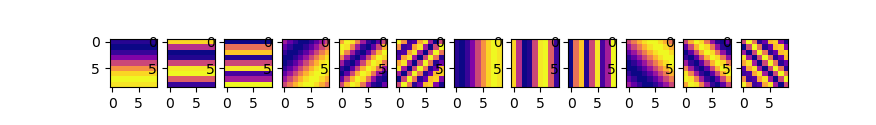

In [4]:
%matplotlib notebook
four_angle_ks = wave_numbers(4)
three_freqs = [0.5, 1.0, 2.0]
sine_kernels = make_sine_kernels(sz=9, ks=four_angle_ks, freqs=three_freqs)
show_filter_bank(sine_kernels)

In [ ]:
%matplotlib notebook
from pathlib import Path
import os
from imageio import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import img_as_uint
import cv2

sz = 128
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
slice_path = Path(os.environ['DATA_ALL']) / 'NIH_DeepLesion' / 'Images_png_01' / 'Images_png' / '000001_01_01' / '108.png'
transverse_slice = imread(slice_path)
transverse_slice = resize(transverse_slice, (sz,sz))
transverse_slice = img_as_uint(transverse_slice)
logging.info(np.histogram(transverse_slice, 10))
transverse_slice = clahe.apply(transverse_slice)
ts_min, ts_max = np.min(transverse_slice), np.max(transverse_slice)
ts_width = ts_max - ts_min
transverse_slice = (transverse_slice - ts_min) / ts_width
transverse_slice = np.reshape(transverse_slice, (1,sz,sz,1))
logging.info(np.histogram(transverse_slice, 10))

transverse_slice_tf = tf.constant(transverse_slice, dtype=tf.float32)
transverse_slice_out_tf = \
    tf.nn.conv2d(transverse_slice_tf, dog_kernels_tf,
                 strides=[1, 1, 1, 1],
                 padding='SAME')

fig, axs = plt.subplots(2,2)
for n in range(4):
    level_img = np.reshape(transverse_slice_out_tf[...,n], (sz,sz))
    axs[n // 2][n % 2].imshow(level_img, cmap='gray', vmin=-.5, vmax=.5)

In [ ]:
%matplotlib notebook
racoon = imread('E:/Users/local_dev/Pictures/racoon.png')
racoon = rgb2gray(resize(racoon, (sz,sz)))

racoon = np.reshape(racoon, (1,sz,sz,1))
racoon_tf = tf.constant(racoon, dtype=tf.float32)

racoon_out_tf = \
    tf.nn.conv2d(racoon_tf, dog_kernels_tf,
                 strides=[1, 1, 1, 1],
                 padding='SAME')

fig, axs = plt.subplots(2,2)
for n in range(4):
    level_img = np.reshape(racoon_out_tf[...,n], (sz,sz))
    axs[n // 2][n % 2].imshow(level_img, cmap='gray', vmin=-.5, vmax=.5)

In [ ]:
%matplotlib notebook
def mse_tf(current_tf:tf.Tensor, kernel_tf:tf.Tensor, match_tf:tf.Tensor):
    current_out_tf = \
        tf.nn.conv2d(current_tf, kernel_tf,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    loss = tf.reduce_mean((current_out_tf - match_tf) ** 2)
    return loss

current_value = tf.Variable(np.zeros((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, dog_kernels_tf, transverse_slice_out_tf)
grad = tape.gradient(current_out, current_value)

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1,2,figsize=(5,3))
learning_rate = 1e+3
for n in range(100):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, dog_kernels_tf, transverse_slice_out_tf)
        logging.info(f"loss = {current_out}   ")
    grad = tape.gradient(current_out, current_value)
axs[0].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray')
axs[1].imshow(tf.reshape(grad, (sz,sz)))
plt.show()